In [1]:
%matplotlib inline
import qcfractal.interface as ptl
import matplotlib.pyplot as plt
import seaborn as sbn
from openeye import oechem
import json
import oenotebook as oenb
import numpy as np
from fragmenter.utils import HARTREE_2_KJMOL
import cmiles
import fragmenter
#import seaborn as sbn

In [2]:
HARTREE_2_KCAL = 627.5
def get_energies_1d(dataset, index):
    """
    Collect energies and Lowdin-Wiberg bond orders from torsiondrive dataset

    Parameters
    ----------
    dataset: QCArchive TorsionDrive dataset
    index: str
        Job index

    Returns
    -------
    final_energies: list of final energy
    wbos: list of WBOs
    """
    angles = np.arange(-165, 195, 15)
    td = dataset.get_record(index, specification='default')
    final_energies =[td.get_final_energies(int(i))*HARTREE_2_KCAL for i in angles]
    final_energies.insert(0, final_energies[-1])
    final_energies = list(np.asarray(final_energies) - min(final_energies))

    wbos = []
    n_atoms = len(td.get_final_molecules(-30).symbols)
    dih = td.keywords.dihedrals[0]
    for a in angles:
        opt = td.get_history(int(a), minimum=True)
        result = opt.get_trajectory()[-1]
        wiberg = np.array(result.extras['qcvars']['WIBERG_LOWDIN_INDICES']).reshape(-1, n_atoms)
        wbos.append(wiberg[dih[1], dih[2]])
    return final_energies, wbos

def get_conformers(dataset, index):
    """
    Download qcschema mols of optimized geometry
    """
    angles = np.arange(-165, 195, 15)
    td = dataset.get_record(index, specification='default')
    final_molecules =[td.get_final_molecules(int(i)).dict(encoding='json') for i in angles]
    return final_molecules



In [3]:
client = ptl.FractalClient()
ds = client.get_collection('TorsionDriveDataset', 'TorsionDrive Paper')

In [4]:
# Analyze scans
record_1d_1 = ds.get_record('[CH2:3]([CH2:2][OH:4])[OH:1]_1', specification='default')
record_1d_12 = ds.get_record('[CH2:3]([CH2:2][OH:4])[OH:1]_12', specification='default')
record_2d_1 = ds.get_record('[CH2:3]([CH2:2][OH:4])[OH:1],[H:4][O:3][CH2:2][CH2:1]O_1', specification='default')
record_2d_12 = ds.get_record('[CH2:3]([CH2:2][OH:4])[OH:1],[H:4][O:3][CH2:2][CH2:1]O_12', specification='default')

In [5]:
# Shift angle so that the y-axis on plot goes from -120 to 240 for better visualization. 
angles_x = [180, -165, -150, -135, -120, -105,  -90,  -75,  -60,  -45,  -30,  -15,
          0,   15,   30,   45,   60,   75,   90,  105,  120,  135,  150,
        165, 180]
angles_y = [ -120, -105,  -90,  -75,  -60,  -45,  -30,  -15,
          0,   15,   30,   45,   60,   75,   90,  105,  120,  135,  150,
        165, 180, -165, -150, -135, -120]

#x=np.unique(angles)
final_energies_1 =[record_1d_1.get_final_energies(int(i))*HARTREE_2_KCAL for i in angles_x]
final_energies_12 = [record_1d_12.get_final_energies(int(i))*HARTREE_2_KCAL for i in angles_x]

In [6]:
final_energies_all = final_energies_1 + final_energies_12
final_energies_all = list(np.asarray(final_energies_all) - min(final_energies_all))

rel_final_energies_1 = list(np.asarray(final_energies_1) - min(final_energies_1))
rel_final_energies_12 = list(np.asarray(final_energies_12) - min(final_energies_12))

In [7]:
conformers_1d_1 = [record_1d_1.get_final_molecules(int(i)).dict(encoding='json') for i in angles_x]
conformers_1d_12 = [record_1d_12.get_final_molecules(int(i)).dict(encoding='json') for i in angles_x]

In [8]:
angles_1d_1 = []
angles_1d_12 = []
dih = record_2d_1.keywords.dihedrals
dih.append((1, 0, 2, 8))
for conf in conformers_1d_1:
    angles_1d_1.append(tuple(fragmenter.torsions.measure_dihedral_angle(d, conf['geometry']) for d in dih))
    
for conf in conformers_1d_12:
    angles_1d_12.append(tuple(fragmenter.torsions.measure_dihedral_angle(d, conf['geometry']) for d in dih))

In [9]:
dih

[(2, 0, 1, 3), (0, 1, 3, 9), (1, 0, 2, 8)]

In [10]:
# After looking at the conformers, I found that when the o-c-c-o torsion was at 45 degrees, the dihedral angles of
# the 2 h-o-c-c-c dihedrals flipped. To make sure I was plotting the h-o-c-c torsion where the H faces the O, I
# take the min of the absolute value of both h-o-c-c dihedrals. 
angles_1d_12_lower = []
for angle in angles_1d_12:
    a = angle[1]
    b = angle[2]
    if abs(a) < abs(b):        
        angles_1d_12_lower.append((angle[0], a))
    else:
        angles_1d_12_lower.append((angle[0], b))

In [11]:
record_2d_1 = ds.get_record('[CH2:3]([CH2:2][OH:4])[OH:1],[H:4][O:3][CH2:2][CH2:1]O_1', specification='default')
record_2d_12 = ds.get_record('[CH2:3]([CH2:2][OH:4])[OH:1],[H:4][O:3][CH2:2][CH2:1]O_12', specification='default')
energy_matrix_12 = np.zeros((25, 25))
for i, a in enumerate(angles_x):
    for j, b in enumerate(angles_y):
        energy = record_2d_12.get_final_energies((int(a), int(b)))*HARTREE_2_KCAL
        energy_matrix_12[i, j] = energy
energy_matrix_12 = energy_matrix_12 - energy_matrix_12.min()        

energy_matrix_1 = np.zeros((25, 25))
for i, a in enumerate(angles_x):
    for j, b in enumerate(angles_y):
        energy = record_2d_1.get_final_energies((int(a), int(b)))*HARTREE_2_KCAL
        energy_matrix_1[i, j] = energy
energy_matrix_1 = energy_matrix_1 - energy_matrix_1.min()        

KeyError: '[120, 0]'

In [12]:
shifted_angels_1d_1 = []
for a in angles_1d_1:
    if a[1] < 0:
        shifted_angels_1d_1.append((a[0], a[1] + 360))
    else:
        shifted_angels_1d_1.append((a[0], a[1]))
        

In [13]:
# Get angles for initial conformations 
mol_1 = client.query_molecules(record_1d_1.initial_molecule)
mol_12 = client.query_molecules(record_1d_12.initial_molecule)
mol_1 = mol_1[0].dict(encoding='json')
initial_angles = tuple(fragmenter.torsions.measure_dihedral_angle(d, mol_1['geometry']) for d in dih)

mol_12s = [m.dict(encoding='json') for m in mol_12]
dihs_initial_12 = []
for mol in mol_12s:
    dihs_initial_12.append(tuple(fragmenter.torsions.measure_dihedral_angle(d, mol['geometry']) for d in dih))

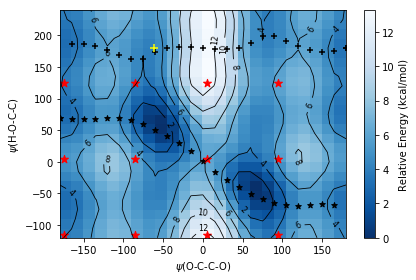

In [17]:
angles_x = [-180, -165, -150, -135, -120, -105,  -90,  -75,  -60,  -45,  -30,  -15,
          0,   15,   30,   45,   60,   75,   90,  105,  120,  135,  150,
        165, 180]
angles_y = [ -120, -105,  -90,  -75,  -60,  -45,  -30,  -15,
          0,   15,   30,   45,   60,   75,   90,  105,  120,  135,  150,
        165, 180, 195, 210, 225, 240]

fig, ax = plt.subplots()
x=np.unique(angles_x)
y=np.unique(angles_y)
X, Y= np.meshgrid(x,y, indexing='ij')

color_map = ax.pcolormesh(X, Y, energy_matrix_12, cmap='Blues_r', label='Energy (kJ/mol)')
CS = ax.contour(X, Y, energy_matrix_12, colors='black', linewidths=0.8)
ax.clabel(CS, inline=1, fontsize=8, fmt='%1.f')

ax.scatter(np.asanyarray(angles_1d_12_lower)[:, 0], np.asanyarray(angles_1d_12_lower)[:, 1], color='black', 
            label='multiple starting conformations', marker='*', s=35)
ax.scatter(np.asanyarray(angles_1d_1)[:, 0], np.asanyarray(shifted_angels_1d_1)[:, 1], color='black', 
            label='single starting conformations', marker='+', s=35)
ax.scatter(initial_angles[0], initial_angles[1]+360, color='yellow', marker='+', s=70)
#           marker='+', s=40)

ax.scatter(np.asanyarray(dihs_initial_12)[:, 0], np.asanyarray(dihs_initial_12)[:, 1], 
           color='red', marker= '*', s=70) 
#            label='multiple starting conformations', marker='*', s=40)
#            label='single starting conformations')

plt.xlim(-180, 180)
plt.ylim(-120, 240)
cbr = fig.colorbar(color_map)
cbr.set_label('Relative Energy (kcal/mol)')
ax.set_xlabel(r'$\psi$(O-C-C-O)')
ax.set_ylabel(r'$\psi$(H-O-C-C)')
#plt.legend()
#plt.legend(bbox_to_anchor=[1.6,1])
fig.tight_layout()
fig.savefig('heatmap.pdf');
#plt.ylim(-80, 80)
#plt.xlim(-180, -50)

In [15]:
# Save conformers of 1D 12 scan for rendering in pymol
oemols = [cmiles.utils.mol_from_json(i) for i in conformers_1d_12]
ofs = oechem.oemolostream()
ofs.open('td_1d_12.xyz')
for mol in oemols:
    oechem.OEWriteXYZFile(ofs, mol)
    
oemols = [cmiles.utils.mol_from_json(i) for i in conformers_1d_1]
ofs = oechem.oemolostream()
ofs.open('td_1d_1.xyz')
for mol in oemols:
    oechem.OEWriteXYZFile(ofs, mol)

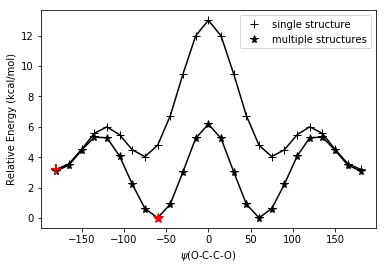

In [16]:
plt.plot(angles_x, final_energies_all[:25], color='black')
plt.plot(angles_x, final_energies_all[:25], '+', color='black', markersize=8, 
         label='single structure')
plt.plot(angles_x, final_energies_all[25:], color='black')

plt.plot(angles_x, final_energies_all[25:], '*', color='black', markersize=8, 
         label='multiple structures')

#plt.plot(angles_x[8], final_energies_all[25+8], '.', color='yellow', markersize=11, )
#plt.plot(angles_x[0], final_energies_all[0], '+', color='yellow', markersize=11, )

plt.plot(angles_x[8], final_energies_all[25+8], '*', color='red', markersize=10)
plt.plot(angles_x[0], final_energies_all[0], '+', color='red', markersize=10, markeredgewidth=2)

#plt.legend(bbox_to_anchor=[1,1])
plt.legend()
plt.xlabel(r'$\psi$(O-C-C-O)')
plt.ylabel('Relative Energy (kcal/mol)');
#plt.tight_layout()
plt.savefig('one_d_scans.pdf')